In [ ]:
!pip install optuna
!pip install lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io

import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from string import punctuation
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
import optuna

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from tabulate import tabulate

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# 1. Data Loading

In [ ]:
# Note: Upload both the reddit_mini.csv and watson_nlu.csv

from google.colab import files
uploaded=files.upload()

Saving reddit_mini.csv to reddit_mini.csv
Saving watson_nlu.csv to watson_nlu.csv


In [ ]:
data = pd.read_csv(io.BytesIO(uploaded['reddit_mini.csv']))
data.head(10)

,usertext,label
0,I just want to end my life so badly. My life i...,1
1,"My relationship is complicated and painful, bu...",1
2,"I owe a lot of money , so I have to work.The c...",1
3,On the 2 of October I overdosed I just felt so...,1
4,"Everyone tells me how wonderful I am, but not ...",1
5,"My last words before my death,For whoever is i...",1
6,I have been struggling for 2 months now with s...,1
7,I had some extremely horrible violent stuff ha...,1
8,This past month has been the worst. 3 1/2 week...,1
9,Hello I am 16 years old and I want to kill mys...,1


In [ ]:
# Using IBM Watson NLU to do sentiment analysis of the dataset and retrieved the following results
watson_data = pd.read_csv(io.BytesIO(uploaded['watson_nlu.csv']))
watson_data.head(10)

,sentiment,anger,sadness,disgust,joy,fear
0,-0.906167,0.272111,0.751128,0.090044,0.012919,0.174592
1,-0.813771,0.133655,0.698303,0.512980,0.040216,0.713078
2,-0.621066,0.167296,0.684554,0.041046,0.025701,0.374354
3,-0.724783,0.126606,0.715237,0.117129,0.006873,0.350638
4,-0.389862,0.849189,0.247317,0.046398,0.036702,0.020026
5,-0.766590,0.094026,0.811678,0.072144,0.067168,0.085556
6,-0.776724,0.214028,0.701725,0.156438,0.057355,0.541238
7,-0.620014,0.145683,0.675013,0.058617,0.589742,0.569385
8,-0.812455,0.154398,0.684534,0.111294,0.088561,0.595274
9,-0.663463,0.460230,0.653503,0.091674,0.576797,0.670715


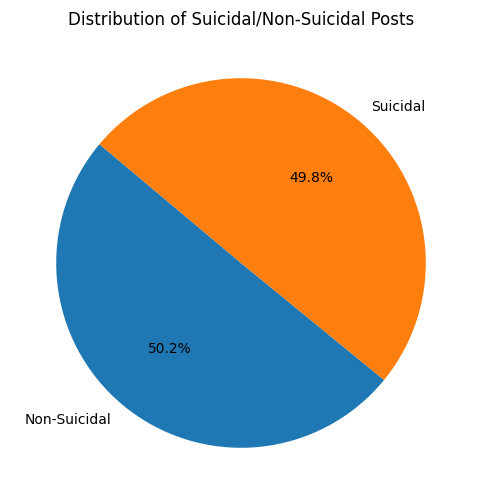

In [ ]:
counts = data['label'].value_counts()
labels = ['Non-Suicidal' if index == 0 else 'Suicidal' for index in counts.index]
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Suicidal/Non-Suicidal Posts')
plt.show()

# 2. Data Preprocessing

In [ ]:
# preprocessing to apply TFIDF
def preprocess_post(post):
  post = post.lower() # convert text to lower-case
  post = post.strip() # removed leading and trailing whitespace
  post = post.encode('ascii', 'ignore').decode('ascii') #remove emojis
  post = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', post) #removed URLs
  post = re.sub(r'\d+','', post) #removed digits
  post = re.sub(r'#([^\s]+)', r'\1', post) # remove hashtag

  # replacing short words
  post = re.sub(r"n\'t", " not", post)
  post = re.sub(r"\'re", " are", post)
  post = re.sub(r"\'s", " is", post)
  post = re.sub(r"\'d", " would", post)
  post = re.sub(r"\'ll", " will", post)
  post = re.sub(r"\'t", " not", post)
  post = re.sub(r"\'ve", " have", post)
  post = re.sub(r"\'m", " am", post)
  post = "".join([c for c in post if c not in string.punctuation])
  post = word_tokenize(post)

  # important stopwords that shouldn't be removed from Choudhary's study.
  ImpStopWords = ['to','i','you','he','she','they','her','we','my','myself','me','no',]
  MyStopWords = []

  for word in stopwords.words('english'):
    if word not in ImpStopWords:
      MyStopWords.append(word)

  FinalWords = []

  lemmatizer = WordNetLemmatizer()

  for word, tag in pos_tag(post):
       if word not in MyStopWords and word.isalpha():
        word_Final = lemmatizer.lemmatize(word)
        FinalWords.append(word_Final)

  post = str(FinalWords)

  return post

print("Preprocessing Posts....")
data['usertext']=data['usertext'].astype('str')
data['label']=data['label'].astype('int')
data['usertext'] = data['usertext'].apply(lambda x: preprocess_post(x))
data['usertext'].head()

Preprocessing Posts....


0    ['i', 'want', 'to', 'end', 'my', 'life', 'badl...
1    ['my', 'relationship', 'complicated', 'painful...
2    ['i', 'owe', 'lot', 'money', 'i', 'to', 'workt...
3    ['october', 'i', 'overdosed', 'i', 'felt', 'al...
4    ['everyone', 'tell', 'me', 'wonderful', 'i', '...
Name: usertext, dtype: object

In [ ]:
print("Applying TFIDF Features....")
Tfidf_vect = TfidfVectorizer(ngram_range=(2,3),max_features=50) # so that it takes 2-3 words combined
X_tfidf = Tfidf_vect.fit_transform(data['usertext'].values.astype('U'))
X_tfidf = pd.DataFrame(X_tfidf.todense())
X_tfidf.columns = X_tfidf.columns.astype(str)
X_tfidf.head()

Applying TFIDF Features....


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.398227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.489187,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.346642,0.0,0.690048,0.355139,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.464973,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0


In [ ]:
# Combining TFIDF Features & Watson NLU Features

final_df = pd.concat([watson_data,X_tfidf],axis=1)
final_df = pd.concat([final_df,data['label']],axis=1)
final_df.head()

,sentiment,anger,sadness,disgust,joy,fear,0,1,2,3,...,41,42,43,44,45,46,47,48,49,label
0,-0.906167,0.272111,0.751128,0.090044,0.012919,0.174592,0.398227,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.489187,0.000000,0.0,0.0,1
1,-0.813771,0.133655,0.698303,0.512980,0.040216,0.713078,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.346642,0.0,0.690048,0.355139,0.0,0.0,1
2,-0.621066,0.167296,0.684554,0.041046,0.025701,0.374354,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.464973,0.000000,0.0,0.0,1
3,-0.724783,0.126606,0.715237,0.117129,0.006873,0.350638,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1
4,-0.389862,0.849189,0.247317,0.046398,0.036702,0.020026,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1


# 3. Model Building

In [ ]:
X = final_df[final_df.columns[:-1]]
Y = final_df['label']
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(X,Y,test_size=0.2, random_state=2000)

### 3.1 Random Forest

In [ ]:
# Finding the best parameters for Random Forest using Bayesian Search

def objective_RF(trial):
    params = {
        # Number of trees in the forest
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),

        # Maximum depth of the tree
        'max_depth': trial.suggest_int('max_depth', 5, 20),

        # Minimum number of samples required to split an internal node
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),

        # Minimum number of samples required to be at a leaf node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 6),

        # Method of selecting samples for training each tree
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),

        # Number of features to consider when looking for the best split
        'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    }

    model = RandomForestClassifier(**params)
    cv_scores = cross_val_score(model, Train_X, Train_Y, cv=5, scoring='accuracy')
    cv_score = np.mean(cv_scores)
    return cv_score


study = optuna.create_study(direction='maximize')
study.optimize(objective_RF, n_trials=25)
best_params_RF = study.best_params
print('Best parameters for RF:', best_params_RF)

[I 2023-12-13 00:52:53,320] A new study created in memory with name: no-name-ec76570b-eea7-4c31-831f-1502e0ae1268
[I 2023-12-13 00:52:57,475] Trial 0 finished with value: 0.8875 and parameters: {'n_estimators': 218, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 0 with value: 0.8875.
[I 2023-12-13 00:53:05,336] Trial 1 finished with value: 0.8674999999999999 and parameters: {'n_estimators': 331, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 0 with value: 0.8875.
[I 2023-12-13 00:53:10,157] Trial 2 finished with value: 0.875 and parameters: {'n_estimators': 351, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.8875.
[I 2023-12-13 00:53:13,705] Trial 3 finished with value: 0.8925000000000001 and parameters: {'n_estimators': 162, 'max_depth': 20, 'min_s

Best parameters for RF: {'n_estimators': 338, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}


In [ ]:
# Random Forest
RF = RandomForestClassifier(**best_params_RF)
RF.fit(Train_X,Train_Y)
predictions_RF = RF.predict(Test_X)

print("RF Accuracy Score -> ",accuracy_score(predictions_RF, Test_Y) * 100)
print("RF Precision Score -> ",precision_score(predictions_RF, Test_Y) * 100)
print("RF Recall Score -> ",recall_score(predictions_RF, Test_Y) * 100)
print("RF F1 Score -> ",f1_score(predictions_RF, Test_Y) * 100)

RF Accuracy Score ->  91.0
RF Precision Score ->  92.0
RF Recall Score ->  90.19607843137256
RF F1 Score ->  91.0891089108911


### 3.2 XGBoost

In [ ]:
# Finding the best hyperparameters for XGBoost using Bayesian Search

# The hyperparameter range for tuning has been set based to maximize accuracy:
# 1. Multile trials were done to tune these hyperparams
# 2. Guide: https://pyligent.github.io/2019-08-20-lightGBM_XGBoost/
def objective_XGB(trial):
    params = {
        # Regularization parameters to prevent overfitting
        'lambda': trial.suggest_float('lambda', 1e-3, 1.0, log=True), # L2

        # Parameters to control the tree structure
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 7),

        # Parameters to control the training process
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),

        # Setting the objective as binary classification
        'objective': 'binary:logistic',
    }

    model = XGBClassifier(**params)
    cv_scores = cross_val_score(model, Train_X, Train_Y, cv=5, scoring='accuracy')
    cv_score = np.mean(cv_scores)
    return cv_score

study = optuna.create_study(direction='maximize')
study.optimize(objective_XGB, n_trials=25)
best_params_XGB = study.best_params
print('Best parameters for XGB:', best_params_XGB)

[I 2023-12-13 00:56:20,781] A new study created in memory with name: no-name-1a528fc8-6b02-49d4-8749-1238ec426a68
[I 2023-12-13 00:56:21,364] Trial 0 finished with value: 0.8875 and parameters: {'lambda': 0.14968884645871133, 'colsample_bytree': 0.7050263300556459, 'subsample': 0.5113618177745246, 'max_depth': 3, 'learning_rate': 0.0494429532965511, 'n_estimators': 143}. Best is trial 0 with value: 0.8875.
[I 2023-12-13 00:56:22,461] Trial 1 finished with value: 0.865 and parameters: {'lambda': 0.03113890511959394, 'colsample_bytree': 0.7988262167640746, 'subsample': 0.8143750420957145, 'max_depth': 6, 'learning_rate': 0.05185665144689859, 'n_estimators': 288}. Best is trial 0 with value: 0.8875.
[I 2023-12-13 00:56:23,178] Trial 2 finished with value: 0.8699999999999999 and parameters: {'lambda': 0.340093063203604, 'colsample_bytree': 0.9046362490791835, 'subsample': 0.6735847523588219, 'max_depth': 4, 'learning_rate': 0.01990600527361848, 'n_estimators': 166}. Best is trial 0 with va

Best parameters for XGB: {'lambda': 0.5644811787966726, 'colsample_bytree': 0.7147728742851575, 'subsample': 0.5670457501417783, 'max_depth': 4, 'learning_rate': 0.026533649506751387, 'n_estimators': 181}


In [ ]:
XGB = XGBClassifier(**best_params_XGB)
XGB.fit(Train_X,Train_Y)
predictions_XGB = XGB.predict(Test_X)

print("XGB Accuracy Score -> ",accuracy_score(predictions_XGB, Test_Y)*100)
print("XGB Precision Score -> ",precision_score(predictions_XGB, Test_Y)*100)
print("XGB Recall Score -> ",recall_score(predictions_XGB, Test_Y)*100)
print("XGB F1 Score -> ",f1_score(predictions_XGB, Test_Y)*100)

XGB Accuracy Score ->  90.0
XGB Precision Score ->  94.0
XGB Recall Score ->  87.03703703703704
XGB F1 Score ->  90.38461538461539


### 3.3 LightGBM

In [ ]:
# Finding the best parameters for LightGBM using Bayesian Search

# The hyperparameter range for tuning has been set based to maximize accuracy:
# 1. Multile trials were done to tune these hyperparams
# 2. Guide: https://pyligent.github.io/2019-08-20-lightGBM_XGBoost/
def objective_LGB(trial):
    params = {
        # Adjusting these to prevent overfitting
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.5), # L2 Regularization

        # Since a lower learning rate with more estimators can yield better results, values have been adjusted accordingly
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),

        # This would make sense if our dataset had unequal classes but we have a balanced dataset, so shouldn't be needed
        # 'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),

        # This should allow adding some level of randomness
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),

        # just to remove un-needed warnings
        'verbose': trial.suggest_int('verbose', -1, -1)
    }

    model = LGBMClassifier(**params)
    cv_scores = cross_val_score(model, Train_X, Train_Y, cv=5, scoring='accuracy')
    cv_score = np.mean(cv_scores)
    return cv_score

study = optuna.create_study(direction='maximize')
study.optimize(objective_LGB, n_trials=25)
best_params_LGB = study.best_params
print('Best parameters for LGB:', best_params_LGB)

[I 2023-12-13 00:57:01,867] A new study created in memory with name: no-name-9f20eefb-64e9-41d6-a9e5-53f8807fbabe
[I 2023-12-13 00:57:02,211] Trial 0 finished with value: 0.875 and parameters: {'num_leaves': 35, 'max_depth': 8, 'reg_lambda': 0.48365153033579356, 'learning_rate': 0.034520097791384666, 'n_estimators': 255, 'subsample': 0.8396966646272639, 'colsample_bytree': 0.7536250538712789, 'verbose': -1}. Best is trial 0 with value: 0.875.
[I 2023-12-13 00:57:03,525] Trial 1 finished with value: 0.8825 and parameters: {'num_leaves': 23, 'max_depth': 7, 'reg_lambda': 0.4464577352232614, 'learning_rate': 0.05960151255815499, 'n_estimators': 450, 'subsample': 0.7783100943754874, 'colsample_bytree': 0.619016476785265, 'verbose': -1}. Best is trial 1 with value: 0.8825.
[I 2023-12-13 00:57:03,696] Trial 2 finished with value: 0.8800000000000001 and parameters: {'num_leaves': 29, 'max_depth': 20, 'reg_lambda': 0.3883931488456949, 'learning_rate': 0.06586530718287742, 'n_estimators': 139, 

Best parameters for LGB: {'num_leaves': 64, 'max_depth': 16, 'reg_lambda': 0.1132239934447456, 'learning_rate': 0.04400672800884869, 'n_estimators': 423, 'subsample': 0.8835365084905273, 'colsample_bytree': 0.7612473027525897, 'verbose': -1}


In [ ]:
LGB = LGBMClassifier(**best_params_LGB)
LGB.fit(Train_X,Train_Y)
predictions_LGB = LGB.predict(Test_X)

print("LGB Accuracy Score -> ",accuracy_score(predictions_LGB, Test_Y) * 100)
print("LGB Precision Score -> ",precision_score(predictions_LGB, Test_Y) * 100)
print("LGB Recall Score -> ",recall_score(predictions_LGB, Test_Y) * 100)
print("LGB F1 Score -> ",f1_score(predictions_LGB, Test_Y) * 100)

LGB Accuracy Score ->  91.0
LGB Precision Score ->  94.0
LGB Recall Score ->  88.67924528301887
LGB F1 Score ->  91.2621359223301


# 4. Model Evaluation

### 4.1 Visualizing the Confusion Matrices

Text(1180.4281045751634, 0.5, 'True Labels')

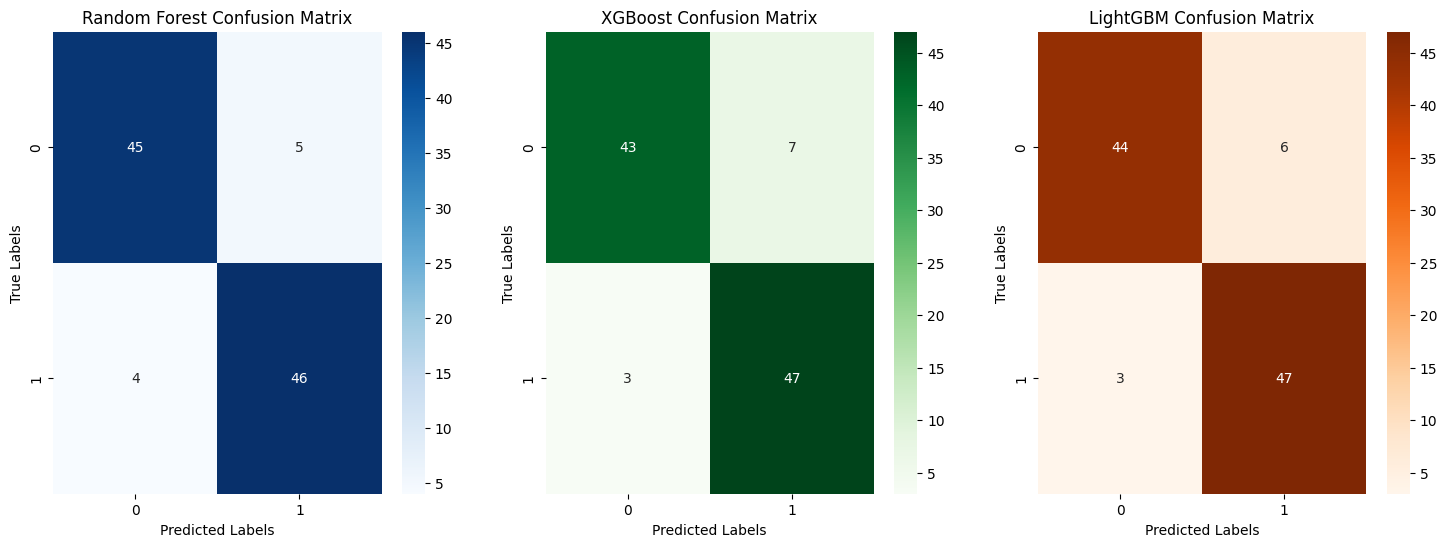

In [ ]:
RF_cm = confusion_matrix(Test_Y, predictions_RF)
XGB_cm = confusion_matrix(Test_Y, predictions_XGB)
LGB_cm = confusion_matrix(Test_Y, predictions_LGB)

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(RF_cm, annot=True, fmt="d", ax=ax[0], cmap='Blues')
ax[0].set_title('Random Forest Confusion Matrix')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

sns.heatmap(XGB_cm, annot=True, fmt="d", ax=ax[1], cmap='Greens')
ax[1].set_title('XGBoost Confusion Matrix')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

sns.heatmap(LGB_cm, annot=True, fmt="d", ax=ax[2], cmap='Oranges')
ax[2].set_title('LightGBM Confusion Matrix')
ax[2].set_xlabel('Predicted Labels')
ax[2].set_ylabel('True Labels')

### 4.2 10-Fold Cross Validation

In [ ]:
avg_result, h = [], ['Model', 'Accuracy', 'Precision', 'Recall', 'F1',]
svm_acc, svm_pre, svm_rec, svm_f1 = [], [], [], []
rf_acc, rf_pre, rf_rec, rf_f1 = [], [], [], []
xgb_acc, xgb_pre, xgb_rec, xgb_f1 = [], [], [], []
lgb_acc, lgb_pre, lgb_rec, lgb_f1 = [], [], [], []

X = final_df[final_df.columns[:-1]]
y = final_df['label']
num_fold = 10
kf = KFold(n_splits=num_fold, shuffle=True, random_state=0)

for train_index, test_index in kf.split(X):
  num_fold -= 1
  train_x, test_x = X.iloc[train_index], X.iloc[test_index]
  train_y, test_y = y.iloc[train_index], y.iloc[test_index]

  # Random Forest
  RF.fit(train_x,train_y)
  predictions_RF = RF.predict(test_x)
  rf_acc.append(accuracy_score(predictions_RF, test_y) * 100)
  rf_pre.append(precision_score(predictions_RF, test_y) * 100)
  rf_rec.append(recall_score(predictions_RF, test_y) * 100)
  rf_f1.append(f1_score(predictions_RF, test_y) * 100)

  # XGBoost
  XGB.fit(train_x,train_y)
  predictions_XGB = XGB.predict(test_x)
  xgb_acc.append(accuracy_score(predictions_XGB, test_y) * 100)
  xgb_pre.append(precision_score(predictions_XGB, test_y) * 100)
  xgb_rec.append(recall_score(predictions_XGB, test_y) * 100)
  xgb_f1.append(f1_score(predictions_XGB, test_y) * 100)

  # LightGBM
  LGB.fit(train_x,train_y)
  predictions_LGB = LGB.predict(test_x)
  lgb_acc.append(accuracy_score(predictions_LGB, test_y) * 100)
  lgb_pre.append(precision_score(predictions_LGB, test_y) * 100)
  lgb_rec.append(recall_score(predictions_LGB, test_y) * 100)
  lgb_f1.append(f1_score(predictions_LGB, test_y) * 100)

# 10-Fold Cross-Validation Results
avg_result.append(['RF', np.mean(rf_acc), np.mean(rf_pre), np.mean(rf_rec), np.mean(rf_f1)])
avg_result.append(['XGB', np.mean(xgb_acc), np.mean(xgb_pre), np.mean(xgb_rec), np.mean(xgb_f1)])
avg_result.append(['LGB', np.mean(lgb_acc), np.mean(lgb_pre), np.mean(lgb_rec), np.mean(lgb_f1)])
print(tabulate(avg_result, headers=h))

Model      Accuracy    Precision    Recall      F1
-------  ----------  -----------  --------  ------
RF             90.6      90.9602   90.2528  90.505
XGB            88.8      89.2708   88.2021  88.656
LGB            88.2      88.3458   87.7541  87.945


### 4.3 Feature Importance
Let's see how the best performing model (Random Forest) does with each feature set individually

In [ ]:
# RF with TFIDF Features only

model = RF

X = final_df[final_df.columns[6:-1]]
y = final_df['label']
tfidf_acc, tfidf_pre, tfidf_rec, tfidf_f1 = [], [], [], []
tfidf_result = []
for train_index, test_index in kf.split(X):
  num_fold -= 1
  train_x, test_x = X.iloc[train_index], X.iloc[test_index]
  train_y, test_y = y.iloc[train_index], y.iloc[test_index]

  model.fit(train_x,train_y)
  predictions_TFIDF = model.predict(test_x)
  tfidf_acc.append(accuracy_score(predictions_TFIDF, test_y)*100)
  tfidf_pre.append(precision_score(predictions_TFIDF, test_y)*100)
  tfidf_rec.append(recall_score(predictions_TFIDF, test_y)*100)
  tfidf_f1.append(f1_score(predictions_TFIDF, test_y)*100)

tfidf_result.append(['RF with TFIDF Features', np.mean(rf_acc), np.mean(rf_pre), np.mean(rf_rec), np.mean(rf_f1)])
print(tabulate(tfidf_result, headers=h))

Model                     Accuracy    Precision    Recall       F1
----------------------  ----------  -----------  --------  -------
RF with TFIDF Features        82.2      79.8875   83.3378  81.1952


In [ ]:
# RF with Sentiment Features only

model = RF

X = final_df[final_df.columns[:6]]
y = final_df['label']
sf_acc, sf_pre, sf_rec, sf_f1 = [], [], [], []
sf_result = []
for train_index, test_index in kf.split(X):
  num_fold -= 1
  train_x, test_x = X.iloc[train_index], X.iloc[test_index]
  train_y, test_y = y.iloc[train_index], y.iloc[test_index]

  model.fit(train_x,train_y)
  predictions_SF = model.predict(test_x)
  sf_acc.append(accuracy_score(predictions_SF, test_y)*100)
  sf_pre.append(precision_score(predictions_SF, test_y)*100)
  sf_rec.append(recall_score(predictions_SF, test_y)*100)
  sf_f1.append(f1_score(predictions_SF, test_y)*100)

sf_result.append(['RF with Sentiment Features', np.mean(sf_acc), np.mean(sf_pre), np.mean(sf_rec), np.mean(sf_f1)])
print(tabulate(sf_result, headers=h))

Model                         Accuracy    Precision    Recall       F1
--------------------------  ----------  -----------  --------  -------
RF with Sentiment Features        85.6      85.9364   85.0695  85.4424
